# Welcome to the FastGarden!

FastGarden is a competition geared towards us veteran `fastai` people who want to give the `fastai2` library a real run for it's money. This competition is based off of the [ImageWoof](https://github.com/fastai/imagewoof) competitions. 

## How does it work?

We have one leaderboard for five epochs. You should get the average of 3 models and report their overall average accuracy and standard deviation.

## The Dataset

We'll be working off of the [Flower Classification with TPUs](https://www.kaggle.com/c/flower-classification-with-tpus/data). This is just for fun as at the moment `fastai2` does not support TPU's, so we ask that you keep this an internal forum-based competition! We'll have full access to the entire dataset, however the final results **must** be on the 224x224 sized images (and at a 224x224 size). IE you can do transfer learning on the 192x192 images and work up to a 224x224 and transfer those weights. (see more info in rules)

## The Rules:

1. No pretrained models allowed from the start*
2. Results must be on the 224x224 dataset `val` folder
3. If training at different resolutions, you must use the `train/val` folder splits
4. Results should be an average of 3 models, with a report of standard deviation as well
5. You are allowed to do partial transfer learning, however you must not go over the **total** number of epochs. IE: train model `A` for 10 epochs, then train model `B` (based on weights from model `A`) for ten epochs only.

# A quick setup example:



To download the dataset, enter the competition at the above link and then download it into your notebook by following Jeremy's directions in [this](https://youtu.be/CzdWqFTmn0Y?list=PLfYUBJiXbdtSyktd8A_x0JNd6lxDcZE96&t=1030) video (yes it's from Intro to ML and yes it still works! :) )

In [ ]:
!wget 'YOUR_URL_HERE' -O 'flowers.zip'

And now we can unzip it

In [ ]:
from zipfile import ZipFile

with ZipFile('flowers.zip', 'r') as zip_ref:
    zip_ref.extractall('flowers/')

## Exploring the data

So let's learn how we set up the data. 

In [ ]:
pip install fastai2 -q

In [ ]:
from fastai2.vision.all import *

We'll work out of the 224x224 image set, but of course we can modify this however we want!

In [ ]:
path = Path('flowers/tfrecords-jpeg-224x224')

In [ ]:
train_fnames = get_files(path/'train', extensions='.tfrec')
test_fnames = get_files(path/'val', extensions='.tfrec')

For extracting the data from the `tfrecord`, we'll be using the [tfrecord](https://github.com/pgmmpk/tfrecord.git) repository

In [ ]:
!git clone https://github.com/pgmmpk/tfrecord.git

In [ ]:
import tensorflow as tf
from tfrecord.tfrecord import *

In order to parse the data, we need to "unpack" each sample to bring it into a `Dataset`. `tfrecord` has two special functions we can use, `unpack_int_64_list` and `unpack_bytes_list` (our classes are integers and our images are bytes)

In [ ]:
def unpack_sample(feats):
    return {
        'class' : unpack_int64_list(feats['class']),
        'image' : unpack_bytes_list(feats['image'])
    }

The current file situation (for this folder) is like so:

* 16 `tfrecord` files each with 792 images for training and testing

How would we split with that? We'll use an index splitter for everything after 12753

In [ ]:
data = []
for name in train_fnames+test_fnames:
  r = Reader(str(name), unpack_sample)
  for sample in r:
    data.append([sample['image'][0], sample['class'][0]])

In [ ]:
len(data)

16465

Now we'll make our getters. They'll operate by grabbing the first and second items from a particular `x`

In [ ]:
get_x = lambda o: PILImage.create(io.BytesIO(o[0]))
get_y = lambda o: o[1]

And as we have the data already loaded into memory, for `get_items` we'll simply return the dataset

In [ ]:
def get_items(noop): return data

In [ ]:
splitter = IndexSplitter(range(12753, len(data)))

Now let's build the `DataBlock`!

In [ ]:
block = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                  get_items=get_items,
                  get_x=get_x,
                  get_y=get_y,
                  splitter=splitter,
                  item_tfms=[Resize(224)],
                  batch_tfms=[*aug_transforms()])

In [ ]:
dls = block.dataloaders('', bs=64)

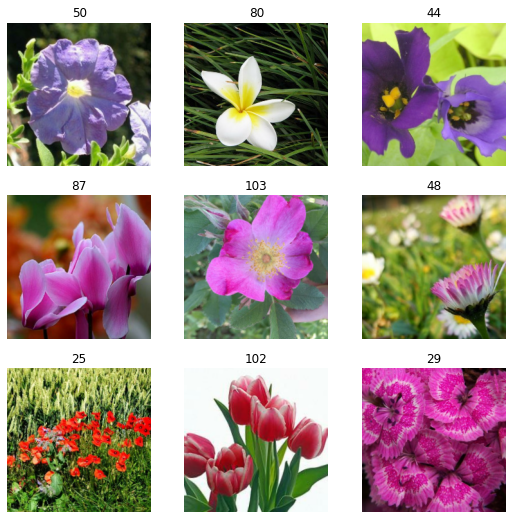

In [ ]:
dls.show_batch()

Now we'll build a model and train!

In [ ]:
net = xresnet50(pretrained=False, sa=True, act_cls=Mish)

In [ ]:
learn = Learner(dls, net, opt_func=ranger, metrics=accuracy)

(0.006918309628963471, 0.007585775572806597)

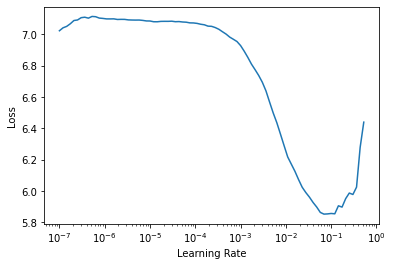

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_flat_cos(5, 1e-2)